# Trust-Aware Mechanism

## One-Max Search (with Maximum Price Predictions)

### Step 1: Load Prediction Results from ML Models

In [365]:
import pandas as pd

df = pd.read_excel('results_of_maximum_price_predictions.xlsx')

In [366]:
df.head()

,date,predicted highest,highest,open,high,low,close
0,2022-09-20,4.224843,4.023,4.006,4.023,3.980,3.991
1,2022-09-21,4.211942,3.990,3.980,3.990,3.943,3.961
2,2022-09-22,4.172879,3.964,3.945,3.964,3.920,3.932
3,2022-09-23,4.163418,3.958,3.932,3.951,3.892,3.924
4,2022-09-26,4.157963,3.958,3.900,3.958,3.894,3.899


#### Divide the data into different groups

In [367]:
df['group'] = df.index // 10
df.head(12)

,date,predicted highest,highest,open,high,low,close,group
0,2022-09-20,4.224843,4.023,4.006,4.023,3.980,3.991,0
1,2022-09-21,4.211942,3.990,3.980,3.990,3.943,3.961,0
2,2022-09-22,4.172879,3.964,3.945,3.964,3.920,3.932,0
3,2022-09-23,4.163418,3.958,3.932,3.951,3.892,3.924,0
4,2022-09-26,4.157963,3.958,3.900,3.958,3.894,3.899,0
5,2022-09-27,4.154618,3.957,3.910,3.957,3.892,3.949,0
6,2022-09-28,4.225002,3.938,3.935,3.938,3.890,3.893,0
7,2022-09-29,4.176115,3.937,3.916,3.937,3.873,3.894,0
8,2022-09-30,4.210713,3.930,3.895,3.915,3.865,3.868,0
9,2022-10-10,4.207784,3.930,3.867,3.870,3.777,3.789,0


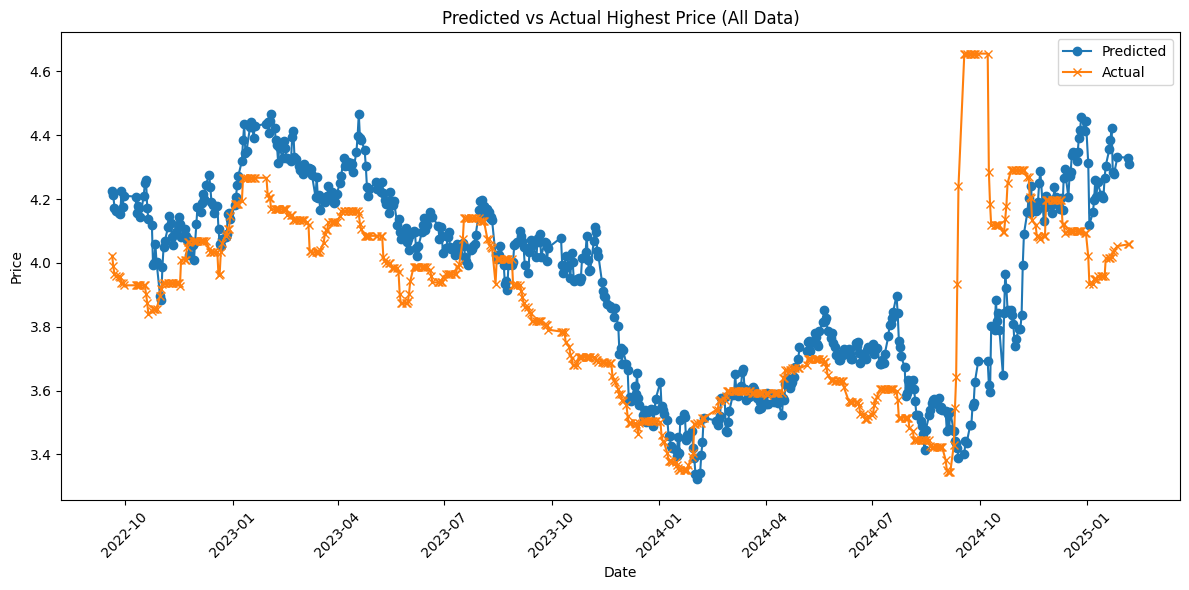

In [368]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df['date'], df['predicted highest'], label='Predicted', marker='o')
plt.plot(df['date'], df['highest'], label='Actual', marker='x')

plt.title('Predicted vs Actual Highest Price (All Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Step 2: Different Online or Learning-Augmented Algorithms

In [369]:
def blindly_trust(L, U, y):
    threshold = y
    return threshold

In [370]:
def El_Yaniv(L, U, y):
    threshold = (L * U) ** (1/2)
    return threshold

In [371]:
def Sun(L, U, y, lambda_):
    theta = U / L
    consistency = (2 * lambda_ * theta) / ( ((1 - lambda_) ** 2 + 4 * lambda_ *  theta) ** (1/2) - (1 - lambda_))
    robustness = theta / consistency
    if y < L * consistency:
        threshold = L * consistency
    elif y < L * robustness:
        threshold = lambda_ * L * robustness + (1 - lambda_) * y / consistency
    else:
        threshold = L * robustness
    return threshold

In [372]:
def Benomar(L, U, y, lambda_):
    theta = U / L
    consistency = (2 * lambda_ * theta) / ( ((1 - lambda_) ** 2 + 4 * lambda_ *  theta) ** (1/2) - (1 - lambda_))
    robustness = theta / consistency
    if y < L * consistency:
        threshold = L * consistency
    elif y < L * robustness:
        threshold = lambda_ * L * robustness + (1 - lambda_) * y / consistency
    else:
        threshold = L * robustness * (lambda_ + (1 - lambda_)/consistency) + ((y - L * robustness)/(U - L * robustness)) * (L * robustness - L * robustness * (lambda_ + (1 - lambda_) / consistency))
    return threshold

In [373]:
def epsilon_Tolerant(L, U, y, lambda_, eps):
    M = lambda_ * (L + 3 * eps) + (1 - lambda_) * ((L * U) ** (1/2) - eps)
    if y <= M - 2 * eps:
        threshold = (L * U) ** (1/2)
    elif y < M:
        threshold = M - eps
    elif y <= (L * U) ** (1/2) + eps:
        threshold = y - eps
    elif y < U - eps:
        mu = ((U - 2 * eps) - (L * U) / (M - eps)) / ((U - 2 * eps) - (L * U) ** (1/2))
        threshold = mu * (L * U) ** (1/2) + (1 - mu) * (y - eps)
    else:
        threshold = (L * U) / (M - eps)
    return threshold

### Step 3: Online Decision-Making

#### Extract the predictions for maximum price (for the next 10 days) on the first day of each group

In [374]:
predicted_first = df.groupby('group').head(1)['predicted highest'].tolist()
#print(predicted_first)

In [375]:
def prediction_to_threshold_blindly_trust(L, U, predictions):
    thresholds = []
    for y in predictions:
        threshold = blindly_trust(L, U, y)
        thresholds.append(threshold)
    return thresholds

# prediction_to_threshold_blindly_trust(3, 5, predicted_first)

In [376]:
def prediction_to_threshold_El_Yaniv(L, U, predictions):
    thresholds = []
    for y in predictions:
        threshold = El_Yaniv(L, U, y)
        thresholds.append(threshold)
    return thresholds

# prediction_to_threshold_El_Yaniv(3, 5, predicted_first)

In [377]:
def prediction_to_threshold_Sun(L, U, predictions, lambda_):
    thresholds = []
    for y in predictions:
        threshold = Sun(L, U, y, lambda_)
        thresholds.append(threshold)
    return thresholds


# prediction_to_threshold_Sun(3, 5, predicted_first, 0.5)

In [378]:
def prediction_to_threshold_Benomar(L, U, predictions, lambda_):
    thresholds = []
    for y in predictions:
        threshold = Benomar(L, U, y, lambda_)
        thresholds.append(threshold)
    return thresholds


# prediction_to_threshold_Benomar(3, 5, predicted_first, 0.5)

In [379]:
def prediction_to_threshold_epsilon_Tolerant(L, U, predictions, lambda_, eps):
    thresholds = []
    for y in predictions:
        threshold = epsilon_Tolerant(L, U, y, lambda_, eps)
        thresholds.append(threshold)
    return thresholds


# prediction_to_threshold_epsilon_Tolerant(3, 5, predicted_first, 0.5, 0.2)

#### Obtain Thresholds for different online or learning-augmented algorithms

In [380]:
L = 3
U = 5
lambda_Sun = 0.22
lambda_Benomar = 0.195
lambda_epsilon_Tolerant = 0.2
eps = 0.2

blindly_trust_thresholds = prediction_to_threshold_blindly_trust(L, U, predicted_first)
El_Yaniv_thresholds = prediction_to_threshold_El_Yaniv(L, U, predicted_first)
Sun_thresholds = prediction_to_threshold_Sun(L, U, predicted_first, lambda_Sun)
Benomar_thresholds = prediction_to_threshold_Benomar(L, U, predicted_first, lambda_Benomar)
epsilon_Tolerant_thresholds = prediction_to_threshold_epsilon_Tolerant(L, U, predicted_first, lambda_epsilon_Tolerant, eps)

In [381]:
def offline_optimal(df):
    rewards = []

    for group_id, group_df in df.groupby('group'):
        best_day = group_df.loc[group_df['highest'].idxmax()]
        rewards.append(best_day['highest'])

    return rewards

offline_optimal_rewards = offline_optimal(df)
print(sum(offline_optimal_rewards))

227.1719999999999


In [382]:
def online_decision_making(df, thresholds):
    rewards = []

    for group_id, group_df in df.groupby('group'):
        threshold = thresholds[group_id]
        converted = False

        for _, row in group_df.iterrows():
            if row['high'] >= threshold:
                rewards.append(row['high']) 
                converted = True
                break

        if not converted:
            rewards.append(group_df.iloc[-1]['close'])

    return rewards

In [383]:
blindly_trust_rewards = online_decision_making(df, blindly_trust_thresholds)
print(sum(blindly_trust_rewards))
El_Yaniv_rewards = online_decision_making(df, El_Yaniv_thresholds)
print(sum(El_Yaniv_rewards))
Sun_rewards = online_decision_making(df, Sun_thresholds)
print(sum(Sun_rewards))
Benomar_rewards = online_decision_making(df, Benomar_thresholds)
print(sum(Benomar_rewards))
epsilon_Tolerant_rewards = online_decision_making(df, epsilon_Tolerant_thresholds)
print(sum(epsilon_Tolerant_rewards))

218.77
220.19
219.91899999999995
219.96699999999996
220.55300000000003


#### Visualization: Empirical Ratios (Cumulative Online / Offline Optimal) Across Rounds

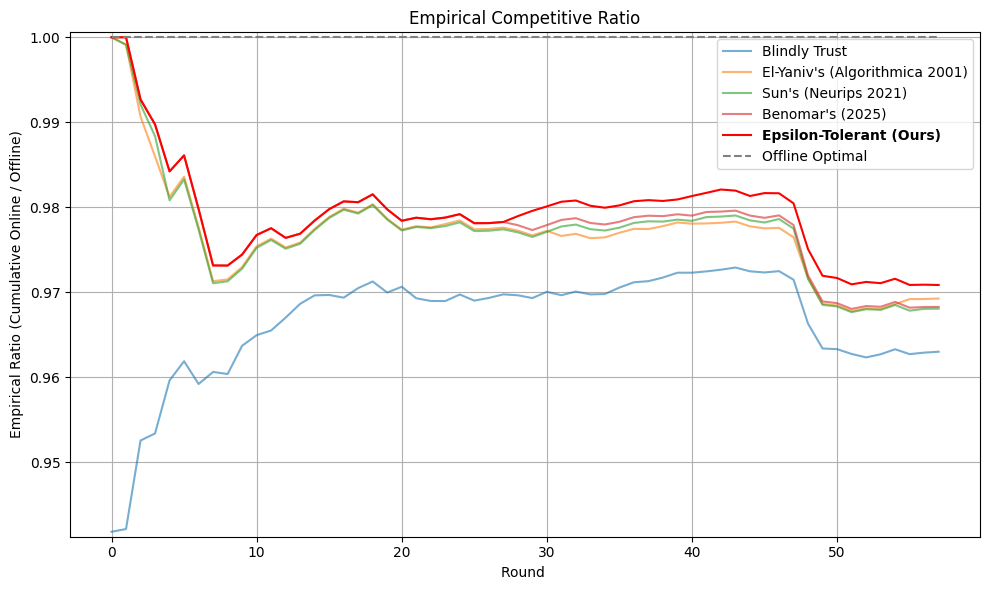

In [384]:
import numpy as np
import matplotlib.pyplot as plt

oracle_cumsum = np.cumsum(offline_optimal_rewards)

blind_cumsum = np.cumsum(blindly_trust_rewards)
El_Yaniv_cumsum = np.cumsum(El_Yaniv_rewards)
Sun_cumsum = np.cumsum(Sun_rewards)
Benomar_cumsum = np.cumsum(Benomar_rewards)
epsilon_cumsum = np.cumsum(epsilon_Tolerant_rewards)

epsilon_safe = 1e-8

blind_ratio = blind_cumsum / (oracle_cumsum + epsilon_safe)
El_Yaniv_ratio = El_Yaniv_cumsum / (oracle_cumsum + epsilon_safe)
Sun_ratio = Sun_cumsum / (oracle_cumsum + epsilon_safe)
Benomar_ratio = Benomar_cumsum / (oracle_cumsum + epsilon_safe)
epsilon_ratio = epsilon_cumsum / (oracle_cumsum + epsilon_safe)

all_ratios = np.vstack([
    blind_ratio, El_Yaniv_ratio, Sun_ratio, Benomar_ratio, epsilon_ratio
])
ymin = np.min(all_ratios)
ymax = np.max(all_ratios)
margin = 0.01 * (ymax - ymin)

plt.figure(figsize=(10, 6))
plt.plot(blind_ratio, label='Blindly Trust', alpha=0.6, linewidth=1.5)
plt.plot(El_Yaniv_ratio, label="El-Yaniv's (Algorithmica 2001)", alpha=0.6, linewidth=1.5)
plt.plot(Sun_ratio, label="Sun's (Neurips 2021)", alpha=0.6, linewidth=1.5)
plt.plot(Benomar_ratio, label="Benomar's (2025)", alpha=0.6, linewidth=1.5)

# Highlight ours in red
plt.plot(epsilon_ratio, label='Epsilon-Tolerant (Ours)', color='red', linewidth=1.5)

plt.plot(np.ones_like(oracle_cumsum), '--', color='gray', label='Offline Optimal')

plt.xlabel('Round ')
plt.ylabel('Empirical Ratio (Cumulative Online / Offline)')
plt.title('Empirical Competitive Ratio')
plt.ylim(ymin - margin, ymax + margin)
plt.legend()
legend = plt.legend(fontsize=10, title_fontsize=11, loc='upper right')
for text in legend.get_texts():
    if 'Epsilon-Tolerant' in text.get_text():
        text.set_fontweight('bold')
plt.grid(True)
plt.tight_layout()
plt.show()